### Predict LOL Esports Winner from 0-30min Realtime Stats using RNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [ ]:
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 0
MAX_TIME_STEP = 30

In [ ]:
from ast import literal_eval

In [ ]:
df = pd.read_csv('/content/LeagueofLegends.csv', sep=',')
df = df[df['gamelength'] >= MAX_TIME_STEP] #only include for first 30 minutes of the game
df.reset_index(drop = True, inplace = True)
matches = len(df)
print(f'# of matches: {matches}')
from ast import literal_eval
df['golddiff'] = df['golddiff'].apply(literal_eval) #converts the string in csv to an array/list
df[['golddiff']].head()

# of matches: 6384


,golddiff
0,"[0, 0, -14, -65, -268, -431, -488, -789, -494,..."
1,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,..."
2,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ..."
3,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ..."
4,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20..."


In [ ]:
def count_item(items):
    count = np.zeros(MAX_TIME_STEP, dtype=np.int8)
    for timestep in range(MAX_TIME_STEP) :
        for item in items:
            if item[0] <= timestep + 1:
                count[timestep] += 1
    return count

df['bDragons'] = df['bDragons'].apply(literal_eval) #converts the string in csv to an array/list
df['rDragons'] = df['rDragons'].apply(literal_eval) #converts the string in csv to an array/list

df['bDragons'] = df['bDragons'].apply(count_item) #counts the number of dragons at each particular timestamp, where bDragons is an array of arrays, where array[0] shows exactly what timetamp a blue dragon was made
df['rDragons'] = df['rDragons'].apply(count_item) #counts the number of dragons at each particular timestamp, where rDragons is an array of arrays, where array[0] shows exactly what timetamp a red dragon was made
df['dragondiff'] = df['bDragons'] - df['rDragons'] #difference in number of dragons at each particular time stamp

df[['dragondiff']].tail()

,dragondiff
6379,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,..."
6380,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,..."
6381,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, ..."
6382,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
6383,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Same logic for the number of barons
df['bBarons'] = df['bBarons'].apply(literal_eval)
df['rBarons'] = df['rBarons'].apply(literal_eval)

df['bBarons'] = df['bBarons'].apply(count_item)
df['rBarons'] = df['rBarons'].apply(count_item)
df['barondiff'] = df['bBarons'] - df['rBarons']

df[['barondiff']].head()

,barondiff
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Same logic for the number of heralds
df['bHeralds'] = df['bHeralds'].apply(literal_eval)
df['rHeralds'] = df['rHeralds'].apply(literal_eval)

df['bHeralds'] = df['bHeralds'].apply(count_item)
df['rHeralds'] = df['rHeralds'].apply(count_item)
df['heralddiff'] = df['bHeralds'] - df['rHeralds']

df[['heralddiff']].head()

,heralddiff
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Same logic for the number of towers
df['bTowers'] = df['bTowers'].apply(literal_eval)
df['rTowers'] = df['rTowers'].apply(literal_eval)

df['bTowers'] = df['bTowers'].apply(count_item)
df['rTowers'] = df['rTowers'].apply(count_item)
df['towerdiff'] = df['bTowers'] - df['rTowers']

df[['towerdiff']].head()

,towerdiff
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, ..."


In [ ]:
#Same logic for the number of inhibitors 
df['bInhibs'] = df['bInhibs'].apply(literal_eval)
df['rInhibs'] = df['rInhibs'].apply(literal_eval)

df['bInhibs'] = df['bInhibs'].apply(count_item)
df['rInhibs'] = df['rInhibs'].apply(count_item)
df['inhibitordiff'] = df['bInhibs'] - df['rInhibs']

df[['inhibitordiff']].head()

,inhibitordiff
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Same logic for the number of kills
df['bKills'] = df['bKills'].apply(literal_eval)
df['rKills'] = df['rKills'].apply(literal_eval)

df['bKills'] = df['bKills'].apply(count_item)
df['rKills'] = df['rKills'].apply(count_item)
df['killdiff'] = df['bKills'] - df['rKills']

df[['killdiff']].head()

,killdiff
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ..."
2,"[0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 5, 5, 5, ..."
3,"[0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, -..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df.to_csv('LoL-modified.csv',index=False)

In [ ]:
# Now let's concatanate the dataset with some additional data that we have collected using the Riot API
df = pd.read_csv('/content/drive/MyDrive/LoL dataset/concated.csv', sep=',')

In [ ]:
df

,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff,winner
0,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1...,0.0
1,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",[ 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2...,1.0
2,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3 3 3...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 1 2 2 1 1 2 2 5 5 5 5 5 7 7 5 5 5 5...,0.0
3,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",[ 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 -1 0 -1 -1 -1 -1 -2 -2 ...,1.0
4,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 -1 -2 -2 -1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0.0
...,...,...,...,...,...,...,...,...
16372,"[0, 0, 0, 246, 1303, 1764, 1696, 2253, 1602, 2...","[0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, -1, -2, -1, -4, -4, -2, -4,...",1.0
16373,"[0, 0, 0, 232, 567, 1370, 1645, 1853, 2324, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, -1, -1, 0, 0, 1, 1, 2, 2...",0.0
16374,"[0, 0, 0, 281, -1334, -833, -774, -826, -322, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 3, 3, 4, 4, 1, ...",1.0
16375,"[0, 0, 0, 64, 617, 2116, 2887, 3467, 4077, 478...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 5, 5, 3, 3, 5, ...",1.0


In [ ]:
#put all stats in an array
stats = ['bDragons', 'rDragons', 'dragondiff', 'bBarons', 'rBarons', 'barondiff', 'bHeralds', 'rHeralds', 'heralddiff', 'bTowers', 'rTowers','towerdiff', 'bInhibs', 'rInhibs','inhibitordiff', 'bKills', 'rKills','killdiff', 'bResult']
temp = df[stats]
temp.to_csv('LoL-relevant.csv',index=False)

In [ ]:
stats = ['golddiff','dragondiff', 'barondiff', 'heralddiff', 'towerdiff', 'inhibitordiff', 'killdiff','bResult']

In [ ]:
data1 = df[stats]

In [ ]:
data1

,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff
0,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ..."
1,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ..."
2,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 5, 5, 5, ..."
3,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, -..."
4,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
16372,"[0, 0, 0, 246, 1303, 1764, 1696, 2253, 1602, 2...","[0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, -1, -2, -1, -4, -4, -2, -4,..."
16373,"[0, 0, 0, 232, 567, 1370, 1645, 1853, 2324, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, -1, -1, 0, 0, 1, 1, 2, 2..."
16374,"[0, 0, 0, 281, -1334, -833, -774, -826, -322, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 3, 3, 4, 4, 1, ..."
16375,"[0, 0, 0, 64, 617, 2116, 2887, 3467, 4077, 478...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 5, 5, 3, 3, 5, ..."


In [ ]:
data1 = data1.rename(columns={"bResult": "winner"}, errors="raise")

Get correlation heatmap between different features in our dataset:

In [ ]:
analysis = pd.DataFrame (literal_eval(data2.iloc[0]["golddiff"]), columns = ['golddiff'])

In [ ]:
analysis = pd.concat([analysis, pd.DataFrame (literal_eval(data2.iloc[0]["dragondiff"]), columns = ['dragondiff'])], axis=1)

In [ ]:
analysis = pd.concat([analysis, pd.DataFrame (literal_eval(data2.iloc[0]["barondiff"]), columns = ['barondiff'])], axis=1)

In [ ]:
analysis = pd.concat([analysis, pd.DataFrame (literal_eval(data2.iloc[0]["towerdiff"]), columns = ['towerdiff'])], axis=1)
analysis = pd.concat([analysis, pd.DataFrame (literal_eval(data2.iloc[0]["heralddiff"]), columns = ['heralddiff'])], axis=1)
analysis = pd.concat([analysis, pd.DataFrame (literal_eval(data2.iloc[0]["inhibitordiff"]), columns = ['inhibitordiff'])], axis=1)
analysis = pd.concat([analysis, pd.DataFrame (literal_eval(data2.iloc[0]["killdiff"]), columns = ['killdiff'])], axis=1)

In [ ]:
analysis.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,golddiff,dragondiff,barondiff,towerdiff,heralddiff,inhibitordiff,killdiff
golddiff,1.00,0.66,0.57,-0.88,-0.88,0.72,0.93
dragondiff,0.66,1.00,0.58,-0.47,-0.46,0.70,0.83
barondiff,0.57,0.58,1.00,-0.35,-0.33,0.75,0.60
towerdiff,-0.88,-0.47,-0.35,1.00,0.90,-0.46,-0.82
heralddiff,-0.88,-0.46,-0.33,0.90,1.00,-0.45,-0.79
inhibitordiff,0.72,0.70,0.75,-0.46,-0.45,1.00,0.75
killdiff,0.93,0.83,0.60,-0.82,-0.79,0.75,1.00


Get correlation heatmap between our features and sample outputs from deep learning model. Shows which features model cares about while making predictions:

In [ ]:
#match_stats['golddiff'] = [0,31,16,122,-71,325,170,367,463,918,1479,1181,689,813,890,1486,2779,2215,2543,2805,2887,2975,3477,3842,3361,3450,3318,3101,754,752]
analysis = pd.read_csv('sample-output.csv')

In [ ]:
analysis = analysis.T

In [ ]:
analysis = analysis.rename(columns={0: "red-win", 1: "blue-win",2:"dragondiff",3:"golddiff",4:"barondiff",5:"heralddiff",6:"towerdiff",7:"inhibitordiff",8:"killdiff"})


In [ ]:
analysis = analysis.drop('red-win',axis=1)

In [ ]:
analysis.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,blue-win,dragondiff,golddiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff
blue-win,1.00,-0.01,0.56,0.65,-0.05,0.17,-0.24,0.71
dragondiff,-0.01,1.00,-0.72,-0.31,-0.30,-0.89,-0.41,-0.43
golddiff,0.56,-0.72,1.00,0.41,0.21,0.83,0.11,0.90
barondiff,0.65,-0.31,0.41,1.00,0.18,0.35,-0.09,0.35
heralddiff,-0.05,-0.30,0.21,0.18,1.00,0.48,0.15,0.22
towerdiff,0.17,-0.89,0.83,0.35,0.48,1.00,0.41,0.58
inhibitordiff,-0.24,-0.41,0.11,-0.09,0.15,0.41,1.00,-0.09
killdiff,0.71,-0.43,0.90,0.35,0.22,0.58,-0.09,1.00


In [ ]:
df = pd.concat([data, data2]).reset_index()

In [ ]:
df["barondiff"]

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
16372    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16373    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16374    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16375    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16376    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: barondiff, Length: 16377, dtype: object

In [ ]:
df.to_csv('LoL-conc.csv',index=False)

In [ ]:
df = pd.read_csv('LoL-conc.csv', sep=',')

In [ ]:
stats = ['golddiff','dragondiff', 'barondiff', 'heralddiff', 'towerdiff', 'inhibitordiff', 'killdiff','bResult']

In [ ]:
data1 = df[stats]

In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/LoL dataset/new_data.csv', sep=',')

In [ ]:
type(data1["golddiff"][0])

list

In [ ]:
data2 = data2.rename(columns={"winner": "bResult"}, errors="raise")

In [ ]:
for i in range(len(data2["golddiff"])):
  data2["golddiff"][i] = literal_eval(data2["golddiff"][i])

In [ ]:
for i in range(len(data2["dragondiff"])):
  data2['dragondiff'][i] = np.fromstring(data2['dragondiff'][i][1:-1], dtype=int, sep=',').astype(np.int8)

In [ ]:
for i in range(len(data2["barondiff"])):
  data2['barondiff'][i] = np.fromstring(data2['barondiff'][i][1:-1], dtype=int, sep=',').astype(np.int8)

In [ ]:
for i in range(len(data2["heralddiff"])):
  data2['heralddiff'][i] = np.fromstring(data2['heralddiff'][i][1:-1], dtype=int, sep=',').astype(np.int8)

In [ ]:
for i in range(len(data2["towerdiff"])):
  data2['towerdiff'][i] = np.fromstring(data2['towerdiff'][i][1:-1], dtype=int, sep=',').astype(np.int8)

In [ ]:
for i in range(len(data2["inhibitordiff"])):
  data2['inhibitordiff'][i] = np.fromstring(data2['inhibitordiff'][i][1:-1], dtype=int, sep=',').astype(np.int8)

In [ ]:
for i in range(len(data2["killdiff"])):
  data2['killdiff'][i] = np.fromstring(data2['killdiff'][i][1:-1], dtype=int, sep=',').astype(np.int8)

In [ ]:
data2["bResult"] = data2["bResult"].astype(int)

In [ ]:
data2["barondiff"][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1], dtype=int8)

In [ ]:
data1

,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff,bResult
0,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",1
1,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ...",0
2,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 5, 5, 5, ...",1
3,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, -...",0
4,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...,...
6379,"[0, -8, -187, -37, -92, -164, -229, -424, -256...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -3, -3, -...",0
6380,"[0, 0, -18, -95, 45, -87, -117, 199, 126, 92, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, ...",0
6381,"[0, 0, -86, -39, -207, -349, -60, -140, 187, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -2,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -4, ...",0
6382,"[0, 0, -97, 33, 351, 284, 299, 263, 403, 623, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [ ]:
data2

,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff,bResult
0,"[0, 0, -1720, -1523, -1169, -618, -723, -522, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 2, 1, 0, -1, -2, -2, -3, -3, -...",0
1,"[0, 0, 0, 144, 627, -115, 5, 401, 596, 1107, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -2, -...",1
2,"[0, 0, 0, 208, 634, 1031, 1445, 1671, 2157, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, -1, -4, -3, -3, -5, -6, -4,...",1
3,"[0, 0, 375, 514, 990, 2031, 2618, 2680, 3406, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 2, 3, 3, 4, 3, 3, 3, 4, 4, 4, ...",1
4,"[0, 0, -240, -912, 191, 48, 648, 1041, 1395, 1...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 3, 3, 3, 4, 4, 3, 4, 4, 6, 7, 6, 7, ...",0
...,...,...,...,...,...,...,...,...
9988,"[0, 0, 0, 246, 1303, 1764, 1696, 2253, 1602, 2...","[0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, -1, -2, -1, -4, -4, -2, -4,...",1
9989,"[0, 0, 0, 232, 567, 1370, 1645, 1853, 2324, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, -1, -1, 0, 0, 1, 1, 2, 2...",0
9990,"[0, 0, 0, 281, -1334, -833, -774, -826, -322, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 3, 3, 4, 4, 1, ...",1
9991,"[0, 0, 0, 64, 617, 2116, 2887, 3467, 4077, 478...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 5, 5, 3, 3, 5, ...",1


In [ ]:
for i in range(len(data2["golddiff"])):
  if len(data2["golddiff"][i]) < MAX_TIME_STEP:
    data2.drop([i], inplace = True )

In [ ]:
data2 = data2.reset_index()

In [ ]:
data2

,index,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff,bResult
0,0,"[0, 0, -1720, -1523, -1169, -618, -723, -522, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 2, 1, 0, -1, -2, -2, -3, -3, -...",0
1,2,"[0, 0, 0, 208, 634, 1031, 1445, 1671, 2157, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, -1, -4, -3, -3, -5, -6, -4,...",1
2,8,"[0, 0, 0, 204, 179, 377, 545, 215, 352, 1005, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, -1, -1, -1, -2, -2, -3, -4,...",0
3,9,"[0, 0, -80, -137, 349, 936, 1371, 2100, 2517, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, -1, -1, -1, -4, -3, -4, -5, -3...",1
4,10,"[0, 0, 0, 80, 97, 51, 612, 1615, 1805, 1479, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, -2, -2, -2, -2, -3, -1, 2, 0, ...",0
...,...,...,...,...,...,...,...,...,...
6231,9986,"[0, 0, 0, -56, 570, 1098, 1050, 1492, 1359, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, -1, 0, 1, 1, 1, 0, 0, 0, 0, -3, -5, ...",1
6232,9987,"[0, 0, 0, 85, 563, 170, -12, -41, 233, 728, 73...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, -1, 1, 0, 0, -1, -3, -4, -6, -5, ...",0
6233,9989,"[0, 0, 0, 232, 567, 1370, 1645, 1853, 2324, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, -1, -1, 0, 0, 1, 1, 2, 2...",0
6234,9990,"[0, 0, 0, 281, -1334, -833, -774, -826, -322, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 3, 3, 4, 4, 1, ...",1


In [ ]:
merged_data = pd.concat([data1, data2], axis=0).reset_index()

In [ ]:
df["golddiff"].apply(literal_eval)

0        [0, 0, -14, -65, -268, -431, -488, -789, -494,...
1        [0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...
2        [0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...
3        [0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...
4        [40, 40, 44, -36, 113, 158, -121, -191, 23, 20...
                               ...                        
16372    [0, 0, 0, 246, 1303, 1764, 1696, 2253, 1602, 2...
16373    [0, 0, 0, 232, 567, 1370, 1645, 1853, 2324, 24...
16374    [0, 0, 0, 281, -1334, -833, -774, -826, -322, ...
16375    [0, 0, 0, 64, 617, 2116, 2887, 3467, 4077, 478...
16376    [0, 0, 0, 288, 163, 795, 909, -1335, -1737, -1...
Name: golddiff, Length: 16377, dtype: object

In [ ]:
#put all stats in an array
stats = ['golddiff','dragondiff', 'barondiff', 'heralddiff', 'towerdiff', 'inhibitordiff', 'killdiff']
x = df[stats]
y = df['winner']
feat = x
x.tail()

KeyError: ignored

In [ ]:
#put all stats in an array
stats = ['golddiff','dragondiff', 'barondiff', 'heralddiff', 'towerdiff', 'inhibitordiff', 'killdiff']
x = df[stats]
y = df['bResult']
feat = x
x.tail()

,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff
6379,"[0, -8, -187, -37, -92, -164, -229, -424, -256...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -3, -3, -..."
6380,"[0, 0, -18, -95, 45, -87, -117, 199, 126, 92, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, ..."
6381,"[0, 0, -86, -39, -207, -349, -60, -140, 187, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -2,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -4, ..."
6382,"[0, 0, -97, 33, 351, 284, 299, 263, 403, 623, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6383,"[0, 0, -8, -225, -36, 73, 464, 184, 1171, 1409...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, -1, -1, 0..."


In [ ]:
merged_data = merged_data.drop('index',axis=1)

In [ ]:
data2["dragondiff"][0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2], dtype=int8)

In [ ]:
stats = ['golddiff','dragondiff', 'barondiff', 'heralddiff', 'towerdiff', 'inhibitordiff', 'killdiff']
df = merged_data
x = df[stats]
y = df['bResult']

In [ ]:
y.tail()

12615    1
12616    0
12617    0
12618    1
12619    1
Name: bResult, dtype: int64

Normalize data:

In [ ]:
from sklearn.preprocessing import StandardScaler

data = {}
scalers = {}

for stat in stats:
    print(stat)
    scalers[stat] = StandardScaler()
    for i, row in enumerate(df[stat]):
        if not isinstance(row, list) and not isinstance(row, np.ndarray):
          row = literal_eval(row)
          if not isinstance(df[stat][i], list):
            df[stat][i] = literal_eval(df[stat][i])
        scalers[stat].partial_fit(np.asanyarray(row).reshape(-1, 1))
    data[stat] = [scalers[stat].transform(np.asanyarray(row).reshape(-1, 1)).reshape(-1) for row in df[stat]]

num_features = len(data)
print(f'# of features per timestep: {num_features}')
print(scalers)

golddiff
dragondiff
barondiff
heralddiff
towerdiff
inhibitordiff
killdiff
# of features per timestep: 7
{'golddiff': StandardScaler(), 'dragondiff': StandardScaler(), 'barondiff': StandardScaler(), 'heralddiff': StandardScaler(), 'towerdiff': StandardScaler(), 'inhibitordiff': StandardScaler(), 'killdiff': StandardScaler()}


In [ ]:
data["dragondiff"][0].size

30

Build dataset:

In [ ]:
class LOLDataset(Dataset):
    def __init__(self, data, stats, label):
        self.data =[]
        for t in range(MAX_TIME_STEP):
            self.data.append([[data[stat][i][t] for stat in stats] for i in range(matches)])
        self.label=[i for i in label]
        
    
    def __getitem__(self, item):
        return torch.tensor([ [torch.scalar_tensor(i) for i in x[item]] for x in self.data]), torch.tensor(self.label[item])

    def __len__(self):
        return len(self.label)
            

In [ ]:
matches = len(df)

In [ ]:
matches

12620

## Neural Network Structure

### Recurrent Neural Network (RNN)

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        self.hidden_size = 256
        
        self.rnn= nn.RNN(
            nonlinearity = 'relu',
            input_size = num_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.out = nn.Linear(self.hidden_size, 2)
    
    def forward(self,x):
        r_out, hn = self.rnn(x, torch.zeros(1, len(x), self.hidden_size))
        out = self.out(r_out[:, -1, :])
        return out


In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        self.hidden_size = 256
        
        self.lstm= nn.LSTM(
            input_size = num_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.out = nn.Linear(self.hidden_size, 2)
    
    def forward(self,x):
        r_out, hn = self.lstm(x, torch.zeros(1, len(x), self.hidden_size))
        out = self.out(r_out[:, -1, :])
        return out

## Training

Split the dataset into Train:Valid:Test = 6:2:2, so we can early stop when validation accuracy drops.

Using a batch size of 32 to load dataset for training.

In [ ]:
BATCH_SIZE = 32

dataset = LOLDataset(data, stats, df["bResult"])
test_size = valid_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size - valid_size

trainDataset, validDataset, testDataset = random_split(
    dataset = dataset,
    lengths = [train_size, valid_size, test_size],
    generator = torch.Generator().manual_seed(0)
)

trainLoader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle=True)
validLoader = DataLoader(validDataset, batch_size = BATCH_SIZE)
testLoader = DataLoader(testDataset, batch_size = BATCH_SIZE)

Baseline: Input golddiff, directly output the team with more gold.

In [ ]:
correct = 0
for x, y in dataset:
    if (x[-1][0] > 0) ^ (y == 1) == 0 : correct += 1
print(f'Baseline Accuracy = {correct/matches*100:>.2f}% ')

Baseline Accuracy = 64.50% 


In [ ]:
def train(dataloader, model, loss_fn, optimizer, mute = False):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = Variable(x), Variable(y)

        predict = model(x)
        loss = loss_fn(predict, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 30 == 0 and not mute:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn, loss, validation = False):
    model.eval()
    size = len(dataloader.dataset)
    
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for step,(x,y) in enumerate(dataloader):
            x, y = Variable(x), Variable(y)
            predict = model(x)
            test_loss += loss_fn(predict, y).item()
            correct += (predict.argmax(1) == y).sum().item()
    
    print(f"{'Valid' if validation else 'Test'} Acc:{correct/size:>7f}, Avg Loss: {test_loss/size:>7f}")
    loss.append(test_loss/size)
    return correct/size, loss

In [ ]:
trainLoader

In [ ]:
df

,level_0,golddiff,dragondiff,barondiff,heralddiff,towerdiff,inhibitordiff,killdiff,bResult,index
0,0,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",1,NaN
1,1,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ...",0,NaN
2,2,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 5, 5, 5, ...",1,NaN
3,3,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, -...",0,NaN
4,4,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,NaN
...,...,...,...,...,...,...,...,...,...,...
12615,6231,"[0, 0, 0, -56, 570, 1098, 1050, 1492, 1359, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, -1, 0, 1, 1, 1, 0, 0, 0, 0, -3, -5, ...",1,9986.0
12616,6232,"[0, 0, 0, 85, 563, 170, -12, -41, 233, 728, 73...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, -1, 1, 0, 0, -1, -3, -4, -6, -5, ...",0,9987.0
12617,6233,"[0, 0, 0, 232, 567, 1370, 1645, 1853, 2324, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, -1, -1, 0, 0, 1, 1, 2, 2...",0,9989.0
12618,6234,"[0, 0, 0, 281, -1334, -833, -774, -826, -322, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 3, 3, 4, 4, 1, ...",1,9990.0


### Training RNN

In [ ]:
MUTE = False
EPOCH = 100
LR = 0.0001

loss = []

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

model = RNN()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
loss_func = nn.CrossEntropyLoss()

best_acc = 0
early_stopping = 0
early_stopping_threshold = 5

for epoch in range(1, EPOCH + 1):
    print(f"--------- Epoch #{epoch} ---------")
    train(trainLoader, model, loss_func, optimizer, mute = MUTE)
    valid_acc, loss = test(validLoader, model, loss_func, loss, validation = True)
    if valid_acc > best_acc :
        early_stopping = 0
        best_acc = valid_acc
        torch.save(model.state_dict(), f"./{MAX_TIME_STEP}.pt")
    else :
        early_stopping += 1
        if early_stopping == early_stopping_threshold :
            print(f"Early stopped at epoch #{epoch} with best validation accuracy {best_acc*100:.2f}%.")
            break


RNN(
  (rnn): RNN(7, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=2, bias=True)
)
--------- Epoch #1 ---------
loss: 0.692812  [    0/ 7572]
loss: 0.653865  [  960/ 7572]
loss: 0.636608  [ 1920/ 7572]
loss: 0.632426  [ 2880/ 7572]
loss: 0.512403  [ 3840/ 7572]
loss: 0.544784  [ 4800/ 7572]
loss: 0.359108  [ 5760/ 7572]
loss: 0.413837  [ 6720/ 7572]
Valid Acc:0.772583, Avg Loss: 0.015107
--------- Epoch #2 ---------
loss: 0.497151  [    0/ 7572]
loss: 0.578404  [  960/ 7572]
loss: 0.428825  [ 1920/ 7572]
loss: 0.412515  [ 2880/ 7572]
loss: 0.576429  [ 3840/ 7572]
loss: 0.519753  [ 4800/ 7572]
loss: 0.397062  [ 5760/ 7572]
loss: 0.363366  [ 6720/ 7572]
Valid Acc:0.779319, Avg Loss: 0.014372
--------- Epoch #3 ---------
loss: 0.372040  [    0/ 7572]
loss: 0.645271  [  960/ 7572]
loss: 0.606790  [ 1920/ 7572]
loss: 0.426571  [ 2880/ 7572]
loss: 0.413532  [ 3840/ 7572]
loss: 0.435694  [ 4800/ 7572]
loss: 0.326941  [ 5760/ 7572]
loss: 0.334737  [ 6720/ 7572]
Valid Acc

## Test

Load best models for both RNN and LSTM and test for results:

In [ ]:
model.load_state_dict(torch.load(f"./{MAX_TIME_STEP}.pt"))
acc_RNN = test(testLoader, model, loss_func, loss)

print(f'Model Accuracy = {acc_RNN*100:>.2f}% ')

Test Acc:0.842476, Avg Loss: 0.010327


TypeError: ignored

Text(0, 0.5, 'Loss')

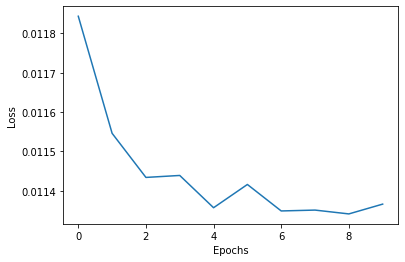

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Sample Match to test our Prediction: EDG vs DK

In [ ]:
match_stats = {}

match_stats['golddiff'] = [0,31,16,122,-71,325,170,367,463,918,1479,1181,689,813,890,1486,2779,2215,2543,2805,2887,2975,3477,3842,3361,3450,3318,3101,754,752]
match_stats['dragondiff'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -3, -4, -4]
match_stats['barondiff'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0]
match_stats['heralddiff'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
match_stats['towerdiff'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2]
match_stats['inhibitordiff'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0]
match_stats['killdiff'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -1, -1]

labels = []
red = []
blue = []

for stat in stats:
    print(stat)
    match_stats[stat] = scalers[stat].transform(np.asanyarray(match_stats[stat]).reshape(-1, 1)).reshape(-1)
    print(match_stats[stat])
    print(scalers[stat])
for i in range(MAX_TIME_STEP):
  max = i+1
  x = np.asarray([[ [match_stats[stat][timestep] for stat in stats] for timestep in range(max) ]], dtype=np.float32)

  model.eval()
  with torch.no_grad():
      x = torch.from_numpy(x)
      predict = model(x)
      winner = ['red', 'blue'][predict.argmax(1)]
      prob_red = math.exp(predict[0][0].item()) / (math.exp(predict[0][0].item()) + math.exp(predict[0][1].item()))
      prob_blue = math.exp(predict[0][1].item()) / (math.exp(predict[0][0].item()) + math.exp(predict[0][1].item()))
      labels.append(max)
      red.append(prob_red*100)
      blue.append(prob_blue*100)
      print(f"model predicted winner: { winner }")
      print(f"red wins: {prob_red * 100 :.1f}% | blue wins: {prob_blue * 100:.1f}%")


golddiff
[-4.52737568e-01 -4.47684203e-01 -4.50129380e-01 -4.32850135e-01
 -4.64311401e-01 -3.99758751e-01 -4.25025571e-01 -3.92912258e-01
 -3.77263131e-01 -3.03092788e-01 -2.11643200e-01 -2.60220699e-01
 -3.40422477e-01 -3.20209021e-01 -3.07657116e-01 -2.10502118e-01
  2.72065501e-04 -9.16665574e-02 -3.81987058e-02  4.51037081e-03
  1.78773337e-02  3.22223671e-02  1.14054262e-01  1.73553548e-01
  9.51448998e-02  1.09652945e-01  8.81353948e-02  5.27618467e-02
 -3.29826714e-01 -3.30152737e-01]
StandardScaler()
dragondiff
[ 0.03621717  0.03621717  0.03621717  0.03621717  0.03621717  0.03621717
  0.03621717  0.03621717  0.03621717  0.03621717  0.03621717 -0.68237508
 -0.68237508 -0.68237508 -0.68237508 -0.68237508 -1.40096733 -1.40096733
 -1.40096733 -1.40096733 -1.40096733 -1.40096733 -2.11955958 -2.11955958
 -2.11955958 -2.11955958 -2.11955958 -2.11955958 -2.83815183 -2.83815183]
StandardScaler()
barondiff
[0.02077332 0.02077332 0.02077332 0.02077332 0.02077332 0.02077332
 0.02077332 0.

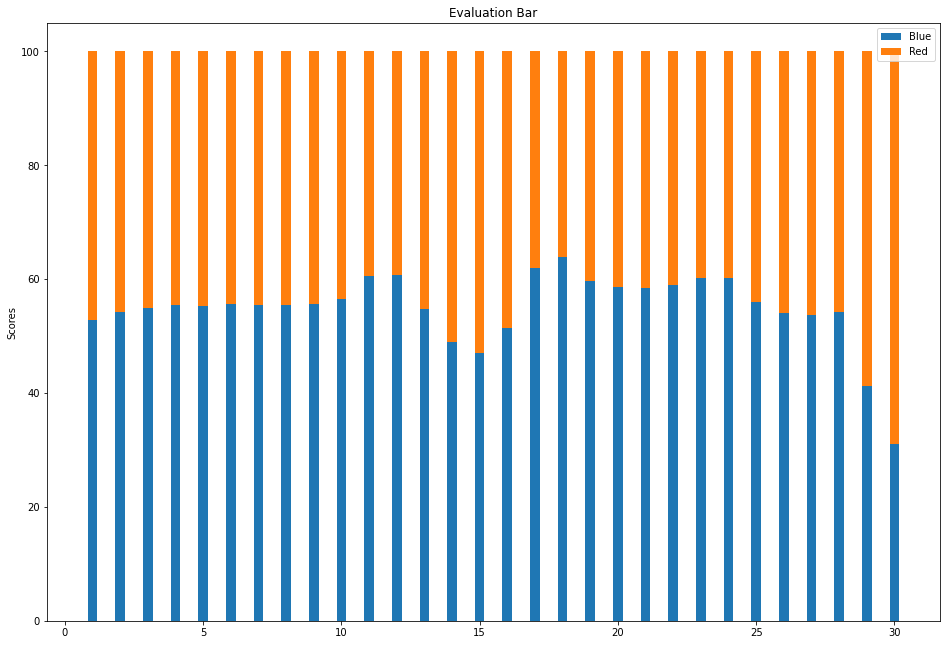

In [ ]:
# Visualization of outputs:
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.rcParams["figure.figsize"] = (16,11)

fig, ax = plt.subplots()

ax.bar(labels, blue, width, label='Blue')
ax.bar(labels, red, width, bottom=blue,
       label='Red')

ax.set_ylabel('Scores')
ax.set_title('Evaluation Bar')
ax.legend()

plt.show()